### 导入项目所需库

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import chinese_calendar

In [2]:
sales = pd.read_csv('inHtl_cii_compfz.csv')

In [3]:
sales

,starttime,hotelid,notcancelcii
0,2015-1-1,352972,217
1,2015-1-1,376834,307
2,2015-1-1,382765,77
3,2015-1-1,400229,55
4,2015-1-1,404224,139
...,...,...,...
195120,2015-12-31,3240256,3
195121,2015-12-31,3574765,3
195122,2015-12-31,3723045,13
195123,2015-12-31,3785874,41


### 检查列名和数据类型

In [4]:
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195125 entries, 0 to 195124
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   starttime     195125 non-null  object
 1   hotelid       195125 non-null  int64 
 2   notcancelcii  195125 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.5+ MB
None


### 检查空值

In [5]:
print(sales.isnull().sum())

starttime       0
hotelid         0
notcancelcii    0
dtype: int64


### 数值列描述性统计

In [6]:
print(sales.describe())

            hotelid  notcancelcii
count  1.951250e+05  195125.00000
mean   1.283487e+06      15.86277
std    6.419448e+05      23.78931
min    1.193080e+05       3.00000
25%    5.492620e+05       3.00000
50%    1.318670e+06       7.00000
75%    1.736546e+06      17.00000
max    4.125367e+06     565.00000


In [7]:
sales['starttime']=pd.to_datetime(sales['starttime'])

In [8]:
sales = sales.assign(
    month=sales['starttime'].dt.month,
    week=sales['starttime'].dt.isocalendar().week,
    weekday=sales['starttime'].dt.weekday + 1
)

In [9]:
sales

,starttime,hotelid,notcancelcii,month,week,weekday
0,2015-01-01,352972,217,1,1,4
1,2015-01-01,376834,307,1,1,4
2,2015-01-01,382765,77,1,1,4
3,2015-01-01,400229,55,1,1,4
4,2015-01-01,404224,139,1,1,4
...,...,...,...,...,...,...
195120,2015-12-31,3240256,3,12,53,4
195121,2015-12-31,3574765,3,12,53,4
195122,2015-12-31,3723045,13,12,53,4
195123,2015-12-31,3785874,41,12,53,4


In [10]:
from chinese_calendar import is_holiday, is_workday

# 1. 添加工作日特征
sales['workday'] = sales['starttime'].apply(is_workday)

# 2. 添加节假日特征
sales['holiday'] = sales['starttime'].apply(is_holiday)

# 3. 打印前5行检查结果
print(sales[['starttime', 'workday', 'holiday']].head())

   starttime  workday  holiday
0 2015-01-01    False     True
1 2015-01-01    False     True
2 2015-01-01    False     True
3 2015-01-01    False     True
4 2015-01-01    False     True


计算均值，标准差，最大最小值

In [11]:
stats = sales.groupby("hotelid")["notcancelcii"].agg(['mean', lambda x: x.std() if len(x) > 1 else 0, 'max', 'min'])
stats = stats.rename(columns={'<lambda_0>': 'std'})
sales = sales.merge(stats, on='hotelid', suffixes=('', '_stat'))
sales = sales.rename(columns={
    'mean': 'sales_mean',
    'std': 'sales_std',
    'max': 'sales_max',
    'min': 'sales_min'
})

In [12]:
sales

,starttime,hotelid,notcancelcii,month,week,weekday,workday,holiday,sales_mean,sales_std,sales_max,sales_min
0,2015-01-01,352972,217,1,1,4,False,True,60.287671,64.110456,375,3
1,2015-01-02,352972,159,1,1,5,False,True,60.287671,64.110456,375,3
2,2015-01-03,352972,33,1,1,6,False,True,60.287671,64.110456,375,3
3,2015-01-04,352972,11,1,1,7,True,False,60.287671,64.110456,375,3
4,2015-01-05,352972,5,1,2,1,True,False,60.287671,64.110456,375,3
...,...,...,...,...,...,...,...,...,...,...,...,...
195120,2015-12-31,4125367,5,12,53,4,True,False,5.000000,0.000000,5,5
195121,2015-12-31,3055603,3,12,53,4,True,False,3.000000,0.000000,3,3
195122,2015-12-31,3884489,9,12,53,4,True,False,9.000000,0.000000,9,9
195123,2015-12-31,4115510,9,12,53,4,True,False,9.000000,0.000000,9,9


In [13]:
# 计算每个 hotelid + month 的平均 notcancelcii 并创建滞后特征
monthly_mean = sales.groupby(['hotelid', 'month'])['notcancelcii'].mean()
sales = sales.merge(
    monthly_mean.groupby('hotelid').shift(1).rename('sales_lag1_mean').reset_index(),
    on=['hotelid', 'month'],
    how='left'
)

# 用每个 hotelid 的全局平均值填充空值
sales['sales_lag1_mean'] = sales['sales_lag1_mean'].fillna(
    sales.groupby('hotelid')['notcancelcii'].transform('mean')
)


In [14]:
# 查看有多少空值被填充
print("填充前的空值数量:", sales['sales_lag1_mean'].isna().sum())  # 应该为0

# 查看1月份的数据（原先为空，现在被填充）
print(sales[sales['month'] == 1][['hotelid', 'sales_lag1_mean']].head())

填充前的空值数量: 0
   hotelid  sales_lag1_mean
0   352972        60.287671
1   352972        60.287671
2   352972        60.287671
3   352972        60.287671
4   352972        60.287671


In [15]:
sales

,starttime,hotelid,notcancelcii,month,week,weekday,workday,holiday,sales_mean,sales_std,sales_max,sales_min,sales_lag1_mean
0,2015-01-01,352972,217,1,1,4,False,True,60.287671,64.110456,375,3,60.287671
1,2015-01-02,352972,159,1,1,5,False,True,60.287671,64.110456,375,3,60.287671
2,2015-01-03,352972,33,1,1,6,False,True,60.287671,64.110456,375,3,60.287671
3,2015-01-04,352972,11,1,1,7,True,False,60.287671,64.110456,375,3,60.287671
4,2015-01-05,352972,5,1,2,1,True,False,60.287671,64.110456,375,3,60.287671
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195120,2015-12-31,4125367,5,12,53,4,True,False,5.000000,0.000000,5,5,5.000000
195121,2015-12-31,3055603,3,12,53,4,True,False,3.000000,0.000000,3,3,3.000000
195122,2015-12-31,3884489,9,12,53,4,True,False,9.000000,0.000000,9,9,9.000000
195123,2015-12-31,4115510,9,12,53,4,True,False,9.000000,0.000000,9,9,9.000000


In [16]:
price = pd.read_csv('hotelminprice_comp.csv')

In [17]:
print(price.info())
print(price.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 934808 entries, 0 to 934807
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   hotelid   934808 non-null  int64  
 1   efdate    934808 non-null  object 
 2   minprice  934808 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 21.4+ MB
None
hotelid     0
efdate      0
minprice    0
dtype: int64


In [18]:
price['efdate']=pd.to_datetime(price['efdate'])

In [19]:
# 按日期排序
sales = sales.sort_values('starttime')
price = price.sort_values('efdate')

# 匹配最近日期的价格
sales = pd.merge_asof(
    sales,
    price,
    left_on='starttime',
    right_on='efdate',
    by='hotelid',
    direction='backward'  # 取最近过去的价格
)



In [20]:
sales = sales.drop(columns=['efdate'])

In [21]:
sales

,starttime,hotelid,notcancelcii,month,week,weekday,workday,holiday,sales_mean,sales_std,sales_max,sales_min,sales_lag1_mean,minprice
0,2015-01-01,352972,217,1,1,4,False,True,60.287671,64.110456,375,3,60.287671,511.0
1,2015-01-01,2178768,13,1,1,4,False,True,7.075188,5.360406,53,3,7.075188,298.0
2,2015-01-01,1206492,21,1,1,4,False,True,18.274238,10.285622,63,3,18.274238,179.0
3,2015-01-01,1207073,41,1,1,4,False,True,19.606232,11.610422,67,3,19.606232,109.0
4,2015-01-01,2145622,31,1,1,4,False,True,19.813187,8.221335,47,3,19.813187,298.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195120,2015-12-31,2170286,3,12,53,4,True,False,4.103448,1.739146,9,3,4.500000,129.0
195121,2015-12-31,1207579,15,12,53,4,True,False,16.650000,10.808011,63,3,17.800000,79.0
195122,2015-12-31,919418,3,12,53,4,True,False,3.814815,1.594149,9,3,5.666667,85.0
195123,2015-12-31,930495,35,12,53,4,True,False,15.408840,9.215712,55,3,14.466667,98.0


In [22]:
print(sales.isnull().sum())

starttime           0
hotelid             0
notcancelcii        0
month               0
week                0
weekday             0
workday             0
holiday             0
sales_mean          0
sales_std           0
sales_max           0
sales_min           0
sales_lag1_mean     0
minprice           12
dtype: int64


In [23]:
sales['minprice'] = sales['minprice'].fillna(sales.groupby('hotelid')['minprice'].transform('mean'))

In [24]:
print(sales.isnull().sum())

starttime          0
hotelid            0
notcancelcii       0
month              0
week               0
weekday            0
workday            0
holiday            0
sales_mean         0
sales_std          0
sales_max          0
sales_min          0
sales_lag1_mean    0
minprice           0
dtype: int64


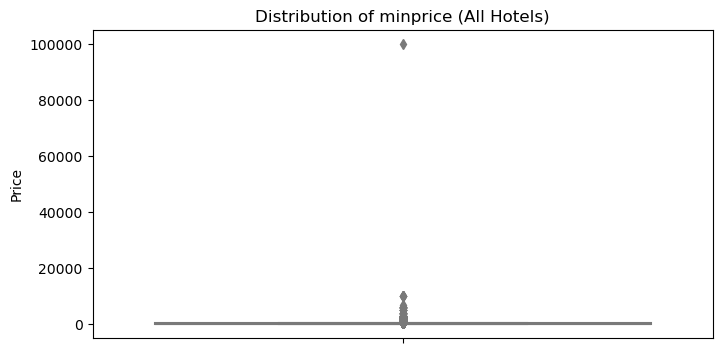

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.boxplot(data=sales, y='minprice', color='lightblue')
plt.title("Distribution of minprice (All Hotels)")
plt.ylabel("Price")
plt.show()

In [26]:
# 计算每个 hotelid 的 99% 分位数
sales['price_99th'] = sales.groupby('hotelid')['minprice'].transform(lambda x: x.quantile(0.99))

# 标记异常值（True=异常值）
sales['is_outlier'] = sales['minprice'] > sales['price_99th']

# 统计异常值数量
outlier_count = sales['is_outlier'].sum()
print(f"异常值总数: {outlier_count}")

# 查看异常值详情
outliers = sales[sales['is_outlier']]
print("\n异常值示例:")
print(outliers[['hotelid', 'starttime', 'minprice', 'price_99th']].head())

异常值总数: 1529

异常值示例:
     hotelid  starttime  minprice  price_99th
14   1928139 2015-01-01      64.0       63.36
41   1815609 2015-01-01     128.0      126.35
51   1752323 2015-01-01     147.0      137.00
52   1507999 2015-01-01     108.0      107.20
124   493151 2015-01-01     198.0      180.00


In [27]:
sales

,starttime,hotelid,notcancelcii,month,week,weekday,workday,holiday,sales_mean,sales_std,sales_max,sales_min,sales_lag1_mean,minprice,price_99th,is_outlier
0,2015-01-01,352972,217,1,1,4,False,True,60.287671,64.110456,375,3,60.287671,511.0,715.76,False
1,2015-01-01,2178768,13,1,1,4,False,True,7.075188,5.360406,53,3,7.075188,298.0,298.00,False
2,2015-01-01,1206492,21,1,1,4,False,True,18.274238,10.285622,63,3,18.274238,179.0,311.00,False
3,2015-01-01,1207073,41,1,1,4,False,True,19.606232,11.610422,67,3,19.606232,109.0,284.00,False
4,2015-01-01,2145622,31,1,1,4,False,True,19.813187,8.221335,47,3,19.813187,298.0,328.00,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195120,2015-12-31,2170286,3,12,53,4,True,False,4.103448,1.739146,9,3,4.500000,129.0,239.00,False
195121,2015-12-31,1207579,15,12,53,4,True,False,16.650000,10.808011,63,3,17.800000,79.0,257.41,False
195122,2015-12-31,919418,3,12,53,4,True,False,3.814815,1.594149,9,3,5.666667,85.0,100.96,False
195123,2015-12-31,930495,35,12,53,4,True,False,15.408840,9.215712,55,3,14.466667,98.0,267.00,False


In [28]:
sales['minprice'] = sales.groupby('hotelid')['minprice'].transform(
    lambda x: x.clip(upper=x.quantile(0.99))
)

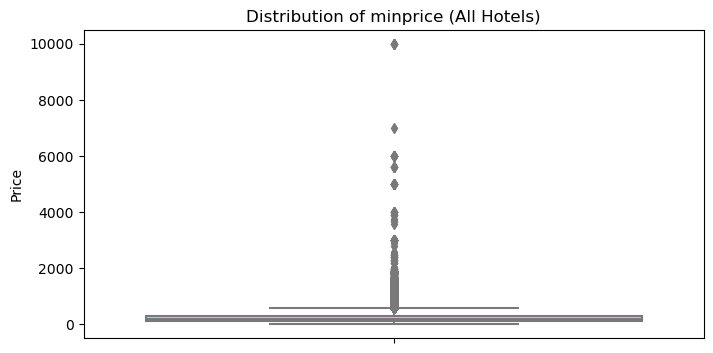

In [29]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=sales, y='minprice', color='lightblue')
plt.title("Distribution of minprice (All Hotels)")
plt.ylabel("Price")
plt.show()

In [30]:
sales

,starttime,hotelid,notcancelcii,month,week,weekday,workday,holiday,sales_mean,sales_std,sales_max,sales_min,sales_lag1_mean,minprice,price_99th,is_outlier
0,2015-01-01,352972,217,1,1,4,False,True,60.287671,64.110456,375,3,60.287671,511.0,715.76,False
1,2015-01-01,2178768,13,1,1,4,False,True,7.075188,5.360406,53,3,7.075188,298.0,298.00,False
2,2015-01-01,1206492,21,1,1,4,False,True,18.274238,10.285622,63,3,18.274238,179.0,311.00,False
3,2015-01-01,1207073,41,1,1,4,False,True,19.606232,11.610422,67,3,19.606232,109.0,284.00,False
4,2015-01-01,2145622,31,1,1,4,False,True,19.813187,8.221335,47,3,19.813187,298.0,328.00,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195120,2015-12-31,2170286,3,12,53,4,True,False,4.103448,1.739146,9,3,4.500000,129.0,239.00,False
195121,2015-12-31,1207579,15,12,53,4,True,False,16.650000,10.808011,63,3,17.800000,79.0,257.41,False
195122,2015-12-31,919418,3,12,53,4,True,False,3.814815,1.594149,9,3,5.666667,85.0,100.96,False
195123,2015-12-31,930495,35,12,53,4,True,False,15.408840,9.215712,55,3,14.466667,98.0,267.00,False


In [31]:
zone=pd.read_csv("hotelstaticinfo_comp.csv")
zone

,hotelid,zone,mgrgroup,gdlat,gdlon,isstraightconnect,star
0,1818,656.0,0.0,31.166143,120.338348,F,3
1,1835,NaN,NaN,NaN,NaN,F,2
2,1866,-1.0,0.0,31.332085,120.578812,F,3
3,1875,211.0,0.0,31.315073,120.620117,F,3
4,1945,NaN,NaN,NaN,NaN,F,2
...,...,...,...,...,...,...,...
8676,4910146,208.0,0.0,NaN,NaN,T,2
8677,4910146,208.0,0.0,31.326521,120.613586,F,2
8678,4910146,208.0,0.0,NaN,NaN,F,2
8679,5052754,-1.0,0.0,NaN,NaN,T,3


In [32]:
print(zone.info())
print(zone.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8681 entries, 0 to 8680
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   hotelid            8681 non-null   int64  
 1   zone               8631 non-null   float64
 2   mgrgroup           8511 non-null   float64
 3   gdlat              3447 non-null   float64
 4   gdlon              3447 non-null   float64
 5   isstraightconnect  8681 non-null   object 
 6   star               8681 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 474.9+ KB
None
hotelid                 0
zone                   50
mgrgroup              170
gdlat                5234
gdlon                5234
isstraightconnect       0
star                    0
dtype: int64


In [33]:
# 检查两表的hotelid重叠度
zone_ids = set(zone['hotelid'].unique())
sales_ids = set(sales['hotelid'].unique())
overlap_ratio = len(zone_ids & sales_ids) / len(sales_ids)
print (overlap_ratio)

1.0


In [34]:
zone['zone'].fillna(-1, inplace=True)

In [35]:
sales = pd.merge(
    sales,
    zone[['hotelid', 'zone', 'star', 'isstraightconnect']],
    on='hotelid',
    how='left'
)

In [36]:
print(sales.isnull().sum())

starttime            0
hotelid              0
notcancelcii         0
month                0
week                 0
weekday              0
workday              0
holiday              0
sales_mean           0
sales_std            0
sales_max            0
sales_min            0
sales_lag1_mean      0
minprice             0
price_99th           0
is_outlier           0
zone                 0
star                 0
isstraightconnect    0
dtype: int64


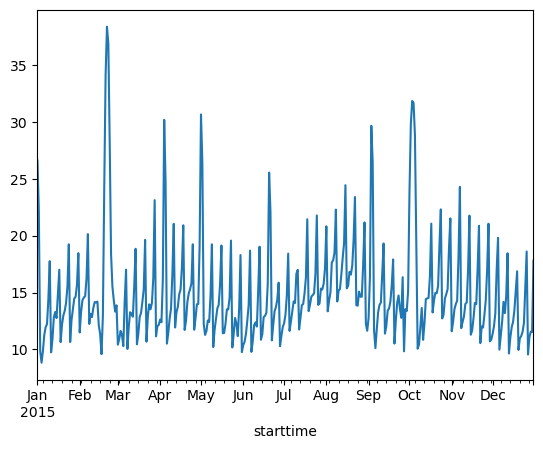

In [37]:
#对'starttime'分组并计算'notcancelcii'的平均值
sales_mean = sales.groupby("starttime")['notcancelcii'].mean()
# 绘制平均值的线形图
sales_mean.plot()
plt.show()

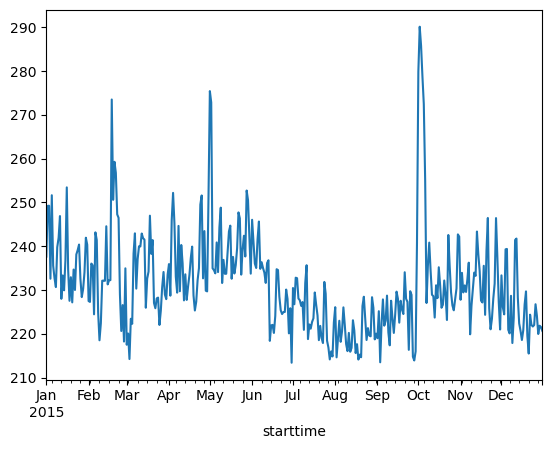

In [38]:
price_mean = sales.groupby("starttime")['minprice'].mean()
price_mean.plot()
plt.show()

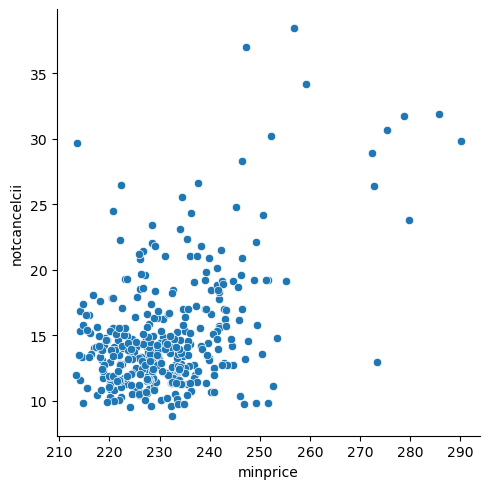

In [39]:
import seaborn as sn
sn.relplot(x=price_mean,y=sales_mean)#绘制散点图
plt.show()

In [40]:
sales_mean = sales_mean.reset_index()

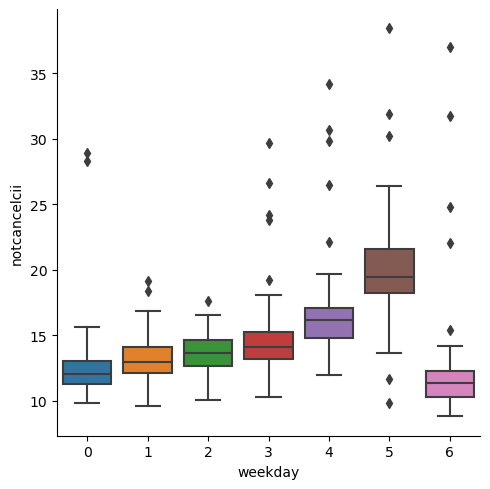

In [41]:
sales_mean['weekday'] = sales_mean['starttime'].dt.dayofweek
sn.catplot(data=sales_mean,x='weekday',y='notcancelcii',kind='box')
plt.show()

d:\anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Glyph 35843 (\N{CJK UNIFIED IDEOGRAPH-8C03}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
d:\anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Glyph 20241 (\N{CJK UNIFIED IDEOGRAPH-4F11}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
d:\anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
d:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 35843 (\N{CJK UNIFIED IDEOGRAPH-8C03}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20241 (\N{CJK UNIFIED IDEOGRAPH-4F11}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserW

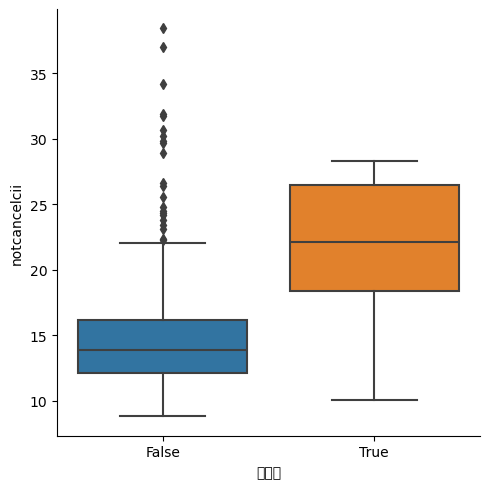

In [42]:
sales_mean['调休日'] = sales_mean['starttime'].apply(lambda x:chinese_calendar.is_in_lieu(x))
sn.catplot(data=sales_mean,x='调休日',y='notcancelcii',kind="box")
plt.show()

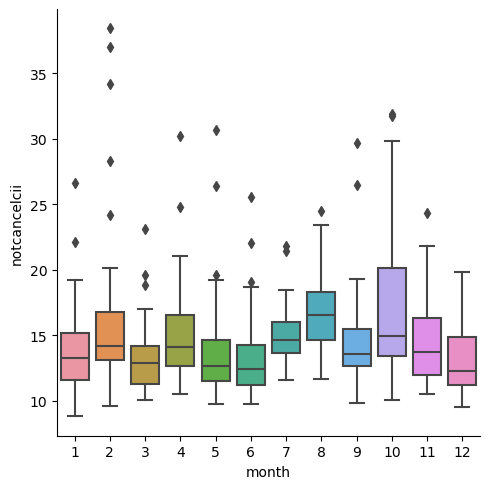

In [43]:
sales_mean['month'] = sales_mean['starttime'].dt.month
sn.catplot(data=sales_mean,x='month',y='notcancelcii',kind='box')
plt.show()

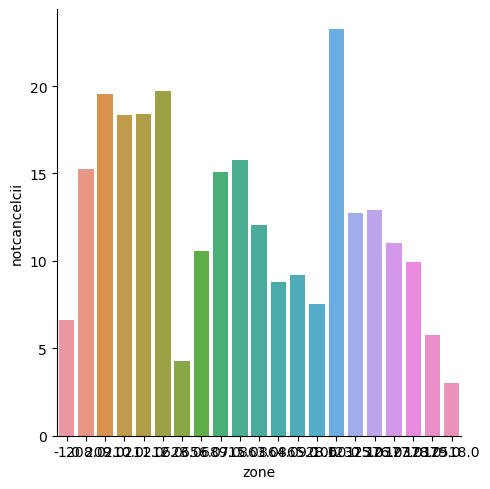

In [44]:
sales_zone = sales.groupby('zone')['notcancelcii'].mean().reset_index()
sn.catplot(data=sales_zone,x='zone',y='notcancelcii',kind="bar")
plt.show()

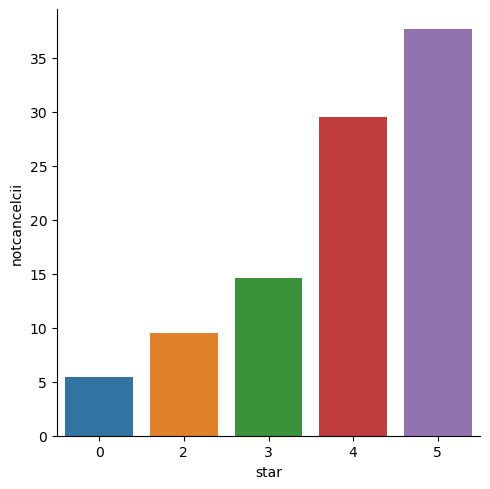

In [45]:
sales_star = sales.groupby('star')['notcancelcii'].mean().reset_index()
sn.catplot(data=sales_star,x='star',y='notcancelcii',kind="bar")
plt.show()

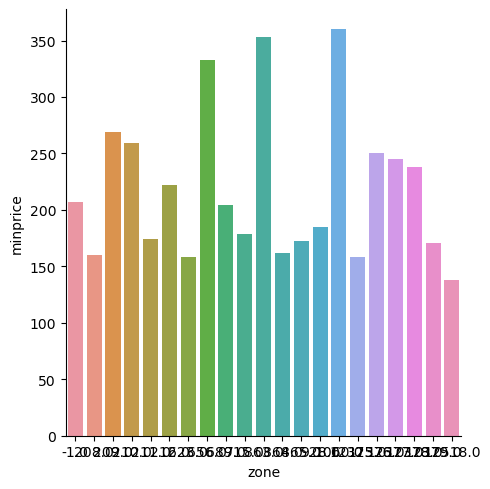

In [46]:
price_zone = sales.groupby('zone')['minprice'].mean().reset_index()
sn.catplot(data=price_zone,x='zone',y='minprice',kind="bar")
plt.show()

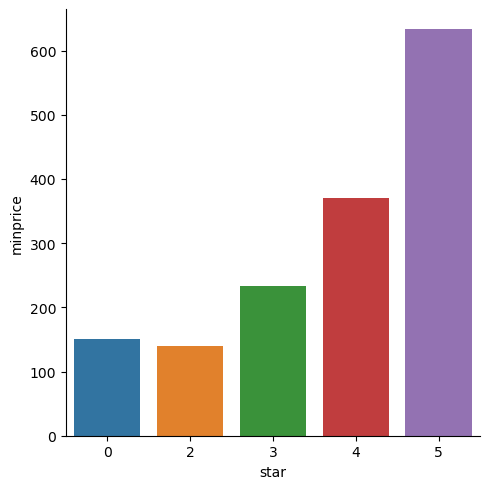

In [47]:
price_star = sales.groupby('star')['minprice'].mean().reset_index()
sn.catplot(data=price_star,x='star',y='minprice',kind="bar")
plt.show()

In [48]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [49]:
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615795 entries, 0 to 615794
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   starttime          615795 non-null  datetime64[ns]
 1   hotelid            615795 non-null  int64         
 2   notcancelcii       615795 non-null  int64         
 3   month              615795 non-null  int32         
 4   week               615795 non-null  UInt32        
 5   weekday            615795 non-null  int32         
 6   workday            615795 non-null  bool          
 7   holiday            615795 non-null  bool          
 8   sales_mean         615795 non-null  float64       
 9   sales_std          615795 non-null  float64       
 10  sales_max          615795 non-null  int64         
 11  sales_min          615795 non-null  int64         
 12  sales_lag1_mean    615795 non-null  float64       
 13  minprice           615795 non-null  float64 

In [50]:
sales = sales.drop(['price_99th', 'is_outlier'], axis=1)

In [51]:
sales

,starttime,hotelid,notcancelcii,month,week,weekday,workday,holiday,sales_mean,sales_std,sales_max,sales_min,sales_lag1_mean,minprice,zone,star,isstraightconnect
0,2015-01-01,352972,217,1,1,4,False,True,60.287671,64.110456,375,3,60.287671,511.0,212.0,5,F
1,2015-01-01,352972,217,1,1,4,False,True,60.287671,64.110456,375,3,60.287671,511.0,212.0,5,F
2,2015-01-01,352972,217,1,1,4,False,True,60.287671,64.110456,375,3,60.287671,511.0,212.0,5,T
3,2015-01-01,2178768,13,1,1,4,False,True,7.075188,5.360406,53,3,7.075188,298.0,210.0,3,T
4,2015-01-01,2178768,13,1,1,4,False,True,7.075188,5.360406,53,3,7.075188,298.0,210.0,3,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615790,2015-12-31,930495,35,12,53,4,True,False,15.408840,9.215712,55,3,14.466667,98.0,689.0,3,T
615791,2015-12-31,930495,35,12,53,4,True,False,15.408840,9.215712,55,3,14.466667,98.0,689.0,3,F
615792,2015-12-31,4124088,3,12,53,4,True,False,3.000000,0.000000,3,3,3.000000,134.0,928.0,2,T
615793,2015-12-31,4124088,3,12,53,4,True,False,3.000000,0.000000,3,3,3.000000,134.0,928.0,2,F


In [52]:
# 定义划分边界
train_end = pd.to_datetime('2015-11-01')
val_end = pd.to_datetime('2015-12-01')

# 按时间划分
train = sales[sales['starttime'] < train_end]                # 2015-01-01 ~ 2015-10-31
val = sales[(sales['starttime'] >= train_end) & (sales['starttime'] < val_end)]  # 2015-11-01 ~ 2015-11-30
test = sales[sales['starttime'] >= val_end]                  # 2015-12-01 ~ 数据结束日

In [53]:
# 验证划分结果
print(f"训练集: {train['starttime'].min().date()} 至 {train['starttime'].max().date()} | 样本数: {len(train)}")
print(f"验证集: {val['starttime'].min().date()} 至 {val['starttime'].max().date()} | 样本数: {len(val)}")
print(f"测试集: {test['starttime'].min().date()} 至 {test['starttime'].max().date()} | 样本数: {len(test)}")

训练集: 2015-01-01 至 2015-10-31 | 样本数: 513483
验证集: 2015-11-01 至 2015-11-30 | 样本数: 52094
测试集: 2015-12-01 至 2015-12-31 | 样本数: 50218


In [54]:
from sklearn.preprocessing import LabelEncoder

# 先对分类变量进行编码
le = LabelEncoder()
sales['isstraightconnect_encoded'] = le.fit_transform(sales['isstraightconnect'].astype(str))
sales[['holiday','workday']] = sales[['holiday','workday']].astype('int8')

# 更新特征列表（用编码后的列替换原列）
features = [
    'month', 'week', 'weekday', 'holiday', 'workday',
    'sales_mean', 'sales_std', 'sales_max', 'sales_min', 
    'sales_lag1_mean',
    'minprice', 'zone', 'star',
    'isstraightconnect_encoded'  # 使用编码后的列
]

# 现在可以安全转换
sales[features] = sales[features].astype(np.float32)

In [55]:
sales

,starttime,hotelid,notcancelcii,month,week,weekday,workday,holiday,sales_mean,sales_std,sales_max,sales_min,sales_lag1_mean,minprice,zone,star,isstraightconnect,isstraightconnect_encoded
0,2015-01-01,352972,217,1.0,1.0,4.0,0.0,1.0,60.287670,64.110458,375.0,3.0,60.287670,511.0,212.0,5.0,F,0.0
1,2015-01-01,352972,217,1.0,1.0,4.0,0.0,1.0,60.287670,64.110458,375.0,3.0,60.287670,511.0,212.0,5.0,F,0.0
2,2015-01-01,352972,217,1.0,1.0,4.0,0.0,1.0,60.287670,64.110458,375.0,3.0,60.287670,511.0,212.0,5.0,T,1.0
3,2015-01-01,2178768,13,1.0,1.0,4.0,0.0,1.0,7.075188,5.360405,53.0,3.0,7.075188,298.0,210.0,3.0,T,1.0
4,2015-01-01,2178768,13,1.0,1.0,4.0,0.0,1.0,7.075188,5.360405,53.0,3.0,7.075188,298.0,210.0,3.0,F,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615790,2015-12-31,930495,35,12.0,53.0,4.0,1.0,0.0,15.408840,9.215712,55.0,3.0,14.466666,98.0,689.0,3.0,T,1.0
615791,2015-12-31,930495,35,12.0,53.0,4.0,1.0,0.0,15.408840,9.215712,55.0,3.0,14.466666,98.0,689.0,3.0,F,0.0
615792,2015-12-31,4124088,3,12.0,53.0,4.0,1.0,0.0,3.000000,0.000000,3.0,3.0,3.000000,134.0,928.0,2.0,T,1.0
615793,2015-12-31,4124088,3,12.0,53.0,4.0,1.0,0.0,3.000000,0.000000,3.0,3.0,3.000000,134.0,928.0,2.0,F,0.0


In [56]:
sales[features].isna().sum()

month                        0
week                         0
weekday                      0
holiday                      0
workday                      0
sales_mean                   0
sales_std                    0
sales_max                    0
sales_min                    0
sales_lag1_mean              0
minprice                     0
zone                         0
star                         0
isstraightconnect_encoded    0
dtype: int64

In [57]:
label = 'notcancelcii'

In [58]:
from sklearn.model_selection import train_test_split
import numpy as np

# 准备特征和目标变量
X = sales[features].values
y = sales['notcancelcii'].values

# 按时间划分数据集（使用之前定义的时间边界）
X_train = X[sales['starttime'] < train_end]
y_train = y[sales['starttime'] < train_end]

X_val = X[(sales['starttime'] >= train_end) & (sales['starttime'] < val_end)]
y_val = y[(sales['starttime'] >= train_end) & (sales['starttime'] < val_end)]

X_test = X[sales['starttime'] >= val_end]
y_test = y[sales['starttime'] >= val_end]

print(f"训练集: {X_train.shape[0]}个样本")
print(f"验证集: {X_val.shape[0]}个样本")
print(f"测试集: {X_test.shape[0]}个样本")

训练集: 513483个样本
验证集: 52094个样本
测试集: 50218个样本


In [59]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 初始化决策树模型
dt = DecisionTreeRegressor(random_state=42)

# 训练模型
dt.fit(X_train, y_train)

# 在验证集上评估
y_val_pred = dt.predict(X_val)
mae_dt = mean_absolute_error(y_val, y_val_pred)
mse_dt = mean_squared_error(y_val, y_val_pred)

print(f"决策树初始模型:")
print(f"验证集MAE: {mae_dt:.2f}")
print(f"验证集MSE: {mse_dt:.2f}")
print(f"验证集RMSE: {np.sqrt(mse_dt):.2f}")

决策树初始模型:
验证集MAE: 8.94
验证集MSE: 260.72
验证集RMSE: 16.15


In [60]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格
param_grid = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 网格搜索
dt_grid = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

dt_grid.fit(X_train, y_train)

# 最佳参数和模型
best_dt = dt_grid.best_estimator_
print(f"最佳参数: {dt_grid.best_params_}")

# 评估优化后的模型
y_val_pred_best = best_dt.predict(X_val)
mae_dt_best = mean_absolute_error(y_val, y_val_pred_best)
mse_dt_best = mean_squared_error(y_val, y_val_pred_best)

print(f"\n优化后决策树:")
print(f"验证集MAE: {mae_dt_best:.2f} (改进: {mae_dt - mae_dt_best:.2f})")
print(f"验证集RMSE: {np.sqrt(mse_dt_best):.2f} (改进: {np.sqrt(mse_dt) - np.sqrt(mse_dt_best):.2f})")

最佳参数: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}

优化后决策树:
验证集MAE: 7.62 (改进: 1.32)
验证集RMSE: 13.01 (改进: 3.13)


In [61]:
from sklearn.ensemble import RandomForestRegressor

# 初始化随机森林模型
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# 训练模型
rf.fit(X_train, y_train)

# 在验证集上评估
y_val_pred_rf = rf.predict(X_val)
mae_rf = mean_absolute_error(y_val, y_val_pred_rf)
mse_rf = mean_squared_error(y_val, y_val_pred_rf)

print(f"随机森林初始模型:")
print(f"验证集MAE: {mae_rf:.2f}")
print(f"验证集RMSE: {np.sqrt(mse_rf):.2f}")

随机森林初始模型:
验证集MAE: 7.20
验证集RMSE: 12.28


In [62]:
# 定义参数网格
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 随机搜索（比网格搜索更快）
from sklearn.model_selection import RandomizedSearchCV

rf_random = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_grid_rf,
    n_iter=10,  # 迭代次数
    cv=2,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

rf_random.fit(X_train, y_train)

# 最佳参数和模型
best_rf = rf_random.best_estimator_
print(f"最佳参数: {rf_random.best_params_}")

# 评估优化后的模型
y_val_pred_rf_best = best_rf.predict(X_val)
mae_rf_best = mean_absolute_error(y_val, y_val_pred_rf_best)
mse_rf_best = mean_squared_error(y_val, y_val_pred_rf_best)

print(f"\n优化后随机森林:")
print(f"验证集MAE: {mae_rf_best:.2f} (改进: {mae_rf - mae_rf_best:.2f})")
print(f"验证集RMSE: {np.sqrt(mse_rf_best):.2f} (改进: {np.sqrt(mse_rf) - np.sqrt(mse_rf_best):.2f})")

最佳参数: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 10}

优化后随机森林:
验证集MAE: 6.84 (改进: 0.37)
验证集RMSE: 11.59 (改进: 0.69)


In [63]:
from xgboost import XGBRegressor

# 初始化XGBoost模型
xgb = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

# 训练模型
xgb.fit(X_train, y_train)

# 在验证集上评估
y_val_pred_xgb = xgb.predict(X_val)
mae_xgb = mean_absolute_error(y_val, y_val_pred_xgb)
mse_xgb = mean_squared_error(y_val, y_val_pred_xgb)

print(f"XGBoost初始模型:")
print(f"验证集MAE: {mae_xgb:.2f}")
print(f"验证集RMSE: {np.sqrt(mse_xgb):.2f}")

XGBoost初始模型:
验证集MAE: 7.10
验证集RMSE: 11.65


In [65]:
# 定义参数网格
param_grid_xgb = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# 使用贝叶斯优化进行更高效的调优
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

search_spaces = {
    'learning_rate': Real(0.01, 0.2, 'log-uniform'),
    'n_estimators': Integer(50, 300),
    'max_depth': Integer(3, 10),
    'subsample': Real(0.7, 1.0),
    'colsample_bytree': Real(0.7, 1.0),
    'gamma': Real(0, 5)
}

xgb_bayes = BayesSearchCV(
    XGBRegressor(random_state=42, n_jobs=-1),
    search_spaces,
    n_iter=10,  # 迭代次数
    cv=2,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

xgb_bayes.fit(X_train, y_train)

# 最佳参数和模型
best_xgb = xgb_bayes.best_estimator_
print(f"最佳参数: {xgb_bayes.best_params_}")

# 评估优化后的模型
y_val_pred_xgb_best = best_xgb.predict(X_val)
mae_xgb_best = mean_absolute_error(y_val, y_val_pred_xgb_best)
mse_xgb_best = mean_squared_error(y_val, y_val_pred_xgb_best)

print(f"\n优化后XGBoost:")
print(f"验证集MAE: {mae_xgb_best:.2f} (改进: {mae_xgb - mae_xgb_best:.2f})")
print(f"验证集RMSE: {np.sqrt(mse_xgb_best):.2f} (改进: {np.sqrt(mse_xgb) - np.sqrt(mse_xgb_best):.2f})")







最佳参数: OrderedDict([('colsample_bytree', 0.8630209203070938), ('gamma', 4.600046132186582), ('learning_rate', 0.04425048888775232), ('max_depth', 9), ('n_estimators', 131), ('subsample', 0.7153403661031155)])

优化后XGBoost:
验证集MAE: 6.89 (改进: 0.21)
验证集RMSE: 11.21 (改进: 0.44)


In [66]:
# 汇总所有模型在验证集上的表现
results = {
    '决策树': {'MAE': mae_dt_best, 'RMSE': np.sqrt(mse_dt_best)},
    '随机森林': {'MAE': mae_rf_best, 'RMSE': np.sqrt(mse_rf_best)},
    'XGBoost': {'MAE': mae_xgb_best, 'RMSE': np.sqrt(mse_xgb_best)}
}

# 找出最佳模型
best_model_name = min(results, key=lambda x: results[x]['RMSE'])
best_model = {
    '决策树': best_dt,
    '随机森林': best_rf,
    'XGBoost': best_xgb
}[best_model_name]

print("\n模型在验证集上的表现比较:")
for model, metrics in results.items():
    print(f"{model}: MAE = {metrics['MAE']:.2f}, RMSE = {metrics['RMSE']:.2f}")

print(f"\n最佳模型是: {best_model_name}")


模型在验证集上的表现比较:
决策树: MAE = 7.62, RMSE = 13.01
随机森林: MAE = 6.84, RMSE = 11.59
XGBoost: MAE = 6.89, RMSE = 11.21

最佳模型是: XGBoost
